In [1]:
import neuron
print(neuron.__version__)

8.2.7+


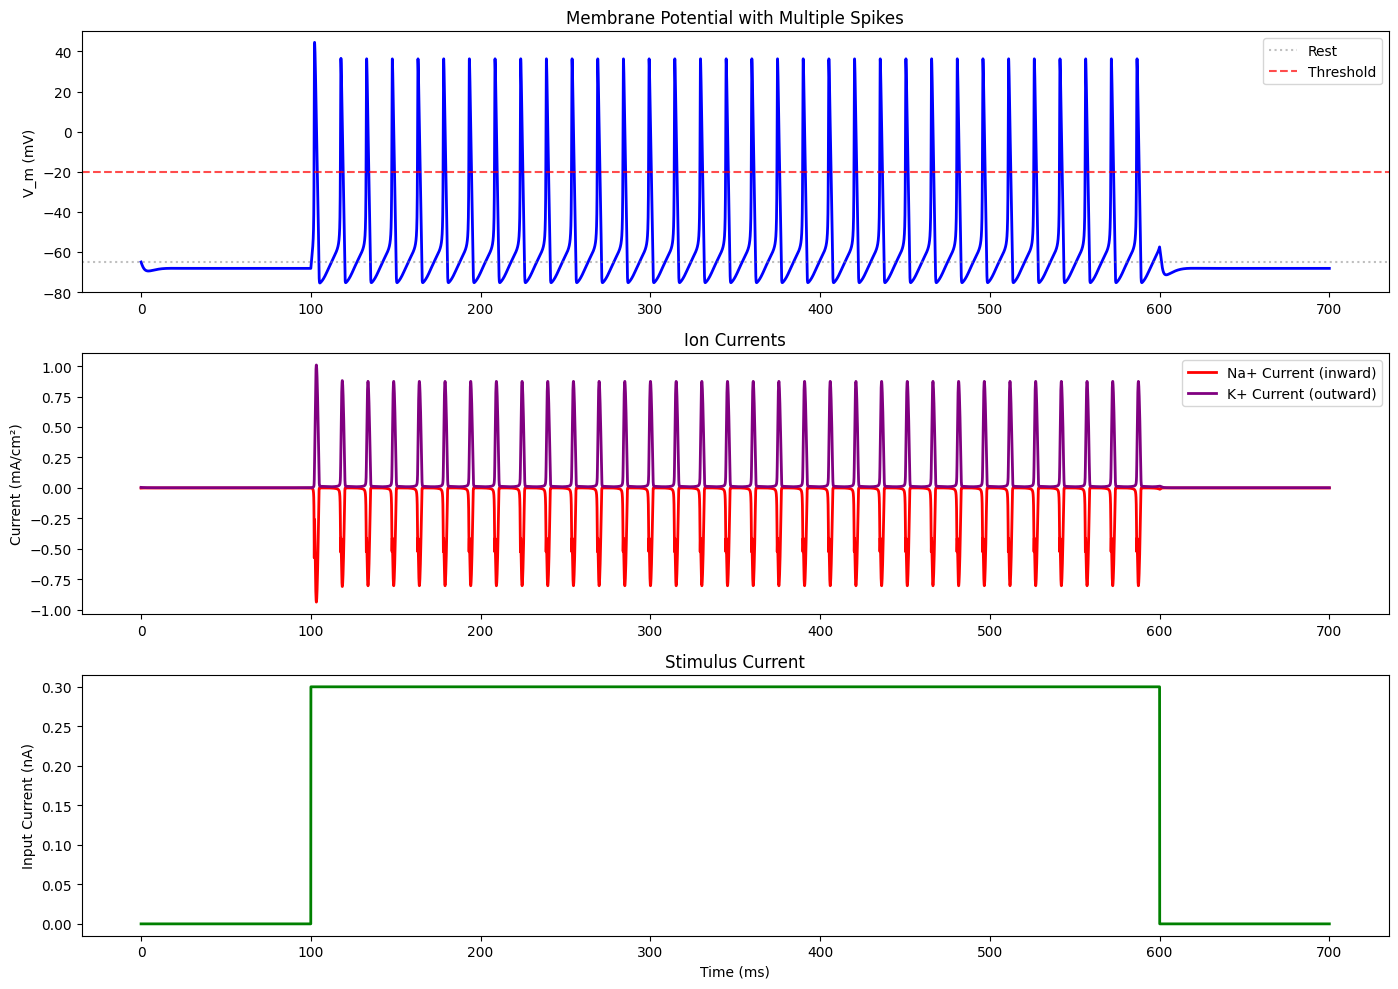

Number of spikes: 33
Mean ISI: 15.14 ms
Firing rate: 66.05 Hz


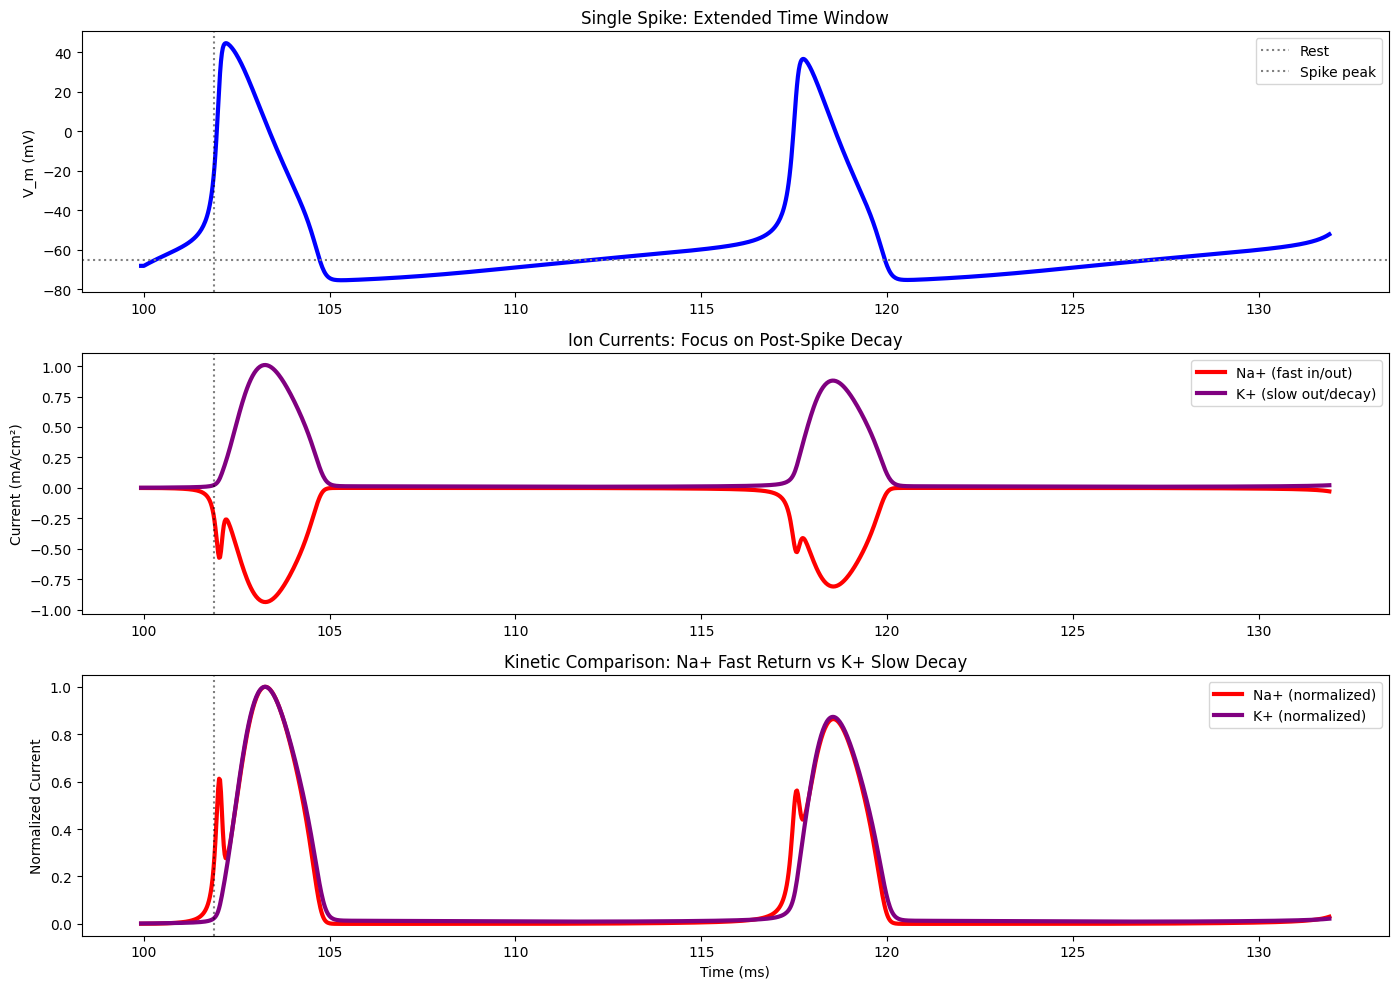

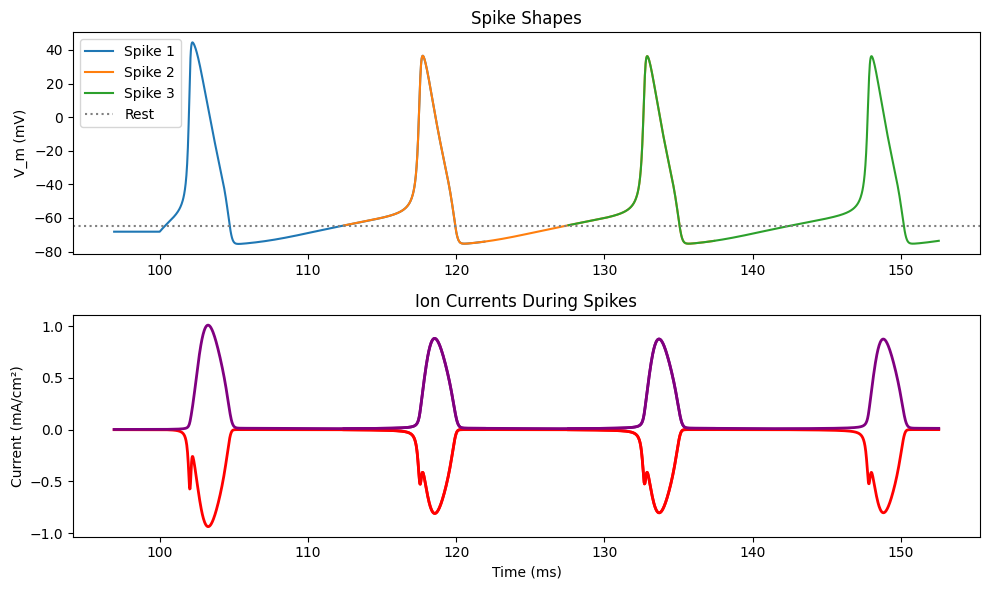

In [2]:
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt

# --- Model setup ---
h.load_file("stdrun.hoc")

soma = h.Section(name='soma')
soma.L = 30
soma.diam = 30
soma.Ra = 100
soma.cm = 1

# Passive properties - reduced leak
soma.insert('pas')
soma.g_pas = 0.00005  # Reduced leak conductance
soma.e_pas = -65

# Active properties - increased sodium conductance
soma.insert('hh')
for seg in soma:
    seg.hh.gnabar = 0.15   # Increased Na+ conductance
    seg.hh.gkbar = 0.036   # K+ conductance  
    seg.hh.gl = 0.0003     # Leak conductance
    seg.hh.el = -65        # Leak reversal

# Stronger current injection
stim = h.IClamp(soma(0.5))
stim.delay = 100
stim.dur = 500
stim.amp = 0.3  # Increased amplitude

# --- Recording vectors ---
t = h.Vector().record(h._ref_t)
v = h.Vector().record(soma(0.5)._ref_v)
ina = h.Vector().record(soma(0.5)._ref_ina)
ik = h.Vector().record(soma(0.5)._ref_ik)

# Spike detection
spike_times = h.Vector()
nc = h.NetCon(soma(0.5)._ref_v, None, sec=soma)
nc.threshold = -20
nc.record(spike_times)

# --- Run simulation ---
h.finitialize(-65)
h.continuerun(700)

# Convert to arrays
t = np.array(t)
v = np.array(v)
ina = np.array(ina)
ik = np.array(ik)
spikes = np.array(list(spike_times))

# --- Plotting ---
plt.figure(figsize=(14, 10))

# Membrane potential
plt.subplot(3, 1, 1)
plt.plot(t, v, 'b', linewidth=2)
plt.axhline(-65, color='gray', linestyle=':', alpha=0.5, label='Rest')
plt.axhline(-20, color='r', linestyle='--', alpha=0.7, label='Threshold')
plt.ylabel('V_m (mV)')
plt.legend()
plt.title('Membrane Potential with Multiple Spikes')
plt.ylim(-80, 50)

# Ion currents
plt.subplot(3, 1, 2)
plt.plot(t, ina, 'r', label='Na+ Current (inward)', linewidth=2)
plt.plot(t, ik, 'purple', label='K+ Current (outward)', linewidth=2)
plt.ylabel('Current (mA/cm²)')
plt.legend()
plt.title('Ion Currents')

# Input current
plt.subplot(3, 1, 3)
input_current = [stim.amp if (stim.delay <= x < stim.delay + stim.dur) else 0 for x in t]
plt.plot(t, input_current, 'g', linewidth=2)
plt.ylabel('Input Current (nA)')
plt.xlabel('Time (ms)')
plt.title('Stimulus Current')

plt.tight_layout()
plt.show()

# Analysis
print(f"Number of spikes: {len(spikes)}")
if len(spikes) > 1:
    isi = np.diff(spikes)
    print(f"Mean ISI: {np.mean(isi):.2f} ms")
    print(f"Firing rate: {1000/np.mean(isi):.2f} Hz")

if len(spikes) > 0:
    plt.figure(figsize=(14, 10))
    
    # Focus on ONE spike with much longer post-spike window
    spike_time = spikes[0]
    single_spike_window = (t >= spike_time - 2) & (t <= spike_time + 30)  # 30ms post-spike
    
    # Membrane potential
    plt.subplot(3, 1, 1)
    plt.plot(t[single_spike_window], v[single_spike_window], 'b', linewidth=3)
    plt.axhline(-65, color='gray', linestyle=':', label='Rest')
    plt.axvline(spike_time, color='k', linestyle=':', alpha=0.5, label='Spike peak')
    plt.ylabel('V_m (mV)')
    plt.title('Single Spike: Extended Time Window')
    plt.legend()
    
    # Ion currents with detailed timing
    plt.subplot(3, 1, 2)
    plt.plot(t[single_spike_window], ina[single_spike_window], 'r', label='Na+ (fast in/out)', linewidth=3)
    plt.plot(t[single_spike_window], ik[single_spike_window], 'purple', label='K+ (slow out/decay)', linewidth=3)
    plt.axvline(spike_time, color='k', linestyle=':', alpha=0.5)
    plt.ylabel('Current (mA/cm²)')
    plt.title('Ion Currents: Focus on Post-Spike Decay')
    plt.legend()
    
    # Normalized currents to compare kinetics
    plt.subplot(3, 1, 3)
    # Normalize to peak values for kinetic comparison
    ina_norm = ina[single_spike_window] / np.min(ina[single_spike_window])
    ik_norm = ik[single_spike_window] / np.max(ik[single_spike_window])
    
    plt.plot(t[single_spike_window], ina_norm, 'r', label='Na+ (normalized)', linewidth=3)
    plt.plot(t[single_spike_window], ik_norm, 'purple', label='K+ (normalized)', linewidth=3)
    plt.axvline(spike_time, color='k', linestyle=':', alpha=0.5)
    plt.ylabel('Normalized Current')
    plt.xlabel('Time (ms)')
    plt.title('Kinetic Comparison: Na+ Fast Return vs K+ Slow Decay')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



# Show spike details
if len(spikes) > 0:
    plt.figure(figsize=(10, 6))
    for i, spike_time in enumerate(spikes[:3]):  # Show first 3 spikes
        window = (t >= spike_time - 5) & (t <= spike_time + 20)
        
        plt.subplot(2, 1, 1)
        plt.plot(t[window], v[window], label=f'Spike {i+1}')
        
        plt.subplot(2, 1, 2)
        plt.plot(t[window], ina[window], 'r', linewidth=2)
        plt.plot(t[window], ik[window], 'purple', linewidth=2)
    
    plt.subplot(2, 1, 1)
    plt.axhline(-65, color='gray', linestyle=':', label='Rest')
    plt.ylabel('V_m (mV)')
    plt.title('Spike Shapes')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.ylabel('Current (mA/cm²)')
    plt.xlabel('Time (ms)')
    plt.title('Ion Currents During Spikes')
    
    plt.tight_layout()
    plt.show()


t[0]=0.0, t[-1]=700.0000000003552
Spike times: []


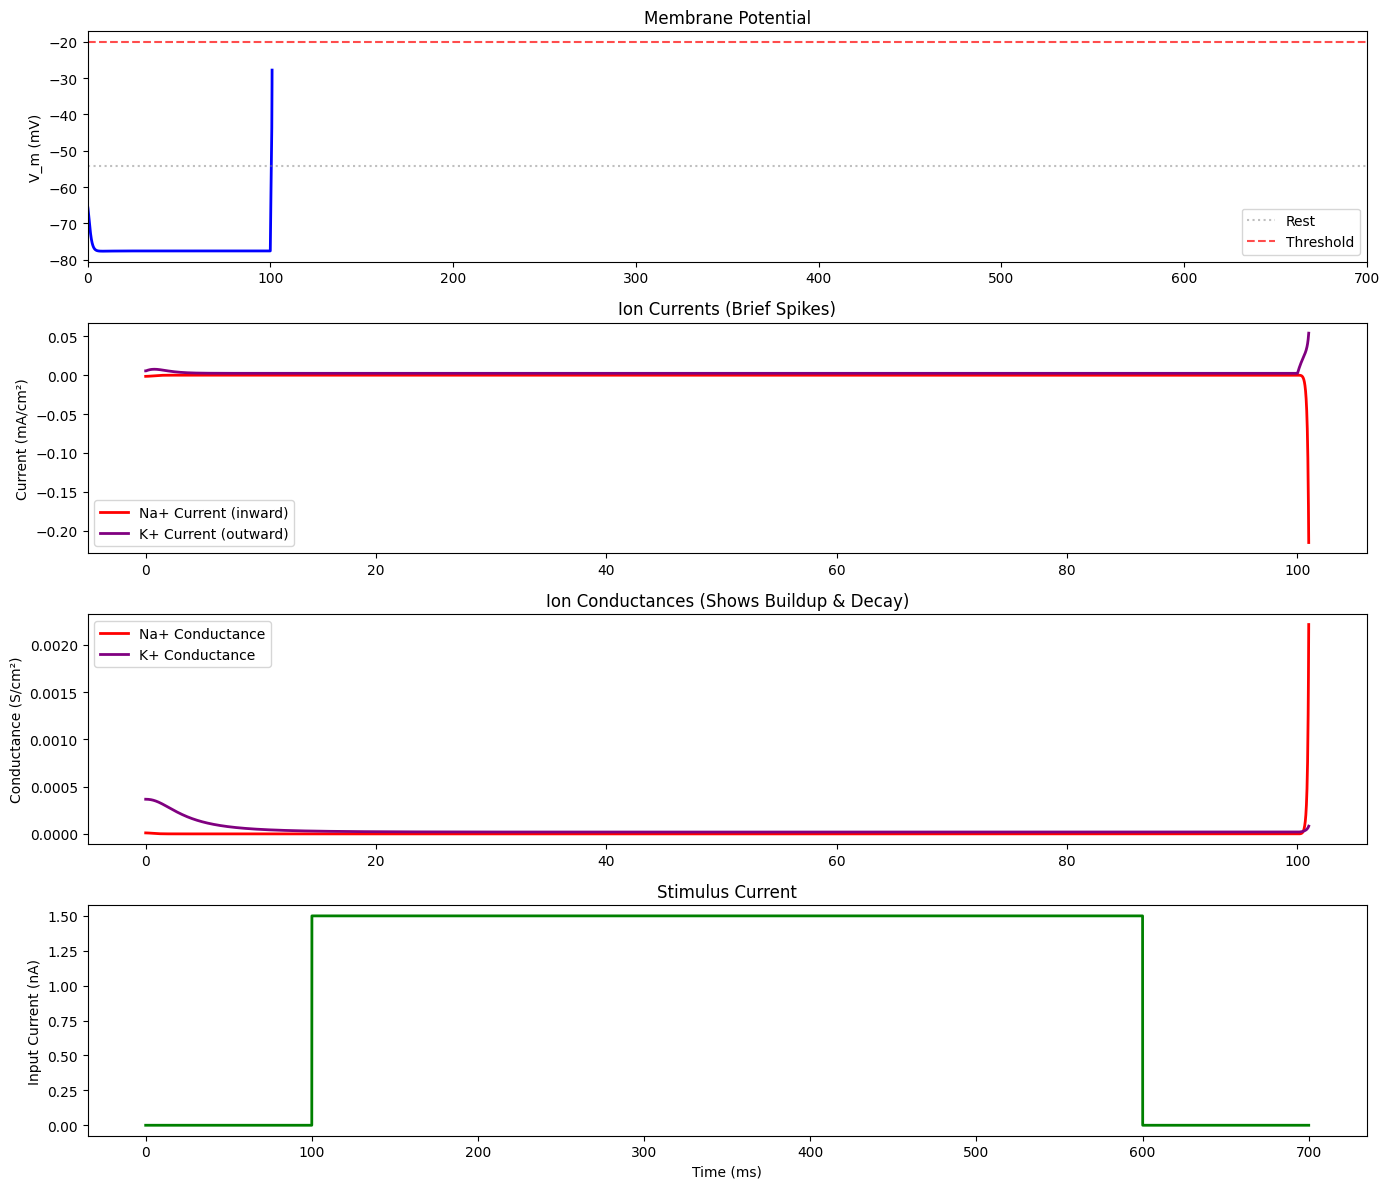

Number of spikes: 0
Max Na+ conductance: nan S/cm²
Max K+ conductance: nan S/cm²
K+ conductance at end: nan S/cm² (should be elevated)


In [5]:
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt

# --- Model setup ---
h.load_file("stdrun.hoc")

soma = h.Section(name='soma')
soma.L = 30
soma.diam = 30
soma.Ra = 100
soma.cm = 1

# Standard Hodgkin-Huxley parameters
soma.insert('hh')
for seg in soma:
    seg.hh.gnabar = 0.15   # Increased Na+ conductance
    seg.hh.gkbar = 0.036 #voltage gated K+ channel
    seg.hh.gl = 0.0001     # Reduced leak
    seg.hh.el = -54.3

soma.insert('cal')
for seg in soma:
    seg.cal.gcalbar = 0.01  # Increased Ca2+ conductance

soma.insert('KCa')
for seg in soma:
    seg.gkbar_KCa = 0.02    # Increased adaptation, Ca2+ activated K+ channel
    seg.ek = -80

# Current injection
stim = h.IClamp(soma(0.5))
stim.delay = 100
stim.dur = 500
stim.amp = 1.5

# Recording vectors
t = h.Vector().record(h._ref_t)
v = h.Vector().record(soma(0.5)._ref_v)
ina = h.Vector().record(soma(0.5)._ref_ina)
ik = h.Vector().record(soma(0.5)._ref_ik)

# Spike detection and recording
spike_times = h.Vector()
nc = h.NetCon(soma(0.5)._ref_v, None, sec=soma)
nc.threshold = -20
nc.record(spike_times)

# NEW: Record gating variables and conductances
m = h.Vector().record(soma(0.5).hh._ref_m)  # Na+ activation
h_gate = h.Vector().record(soma(0.5).hh._ref_h)  # Na+ inactivation
n = h.Vector().record(soma(0.5).hh._ref_n)  # K+ activation

# Run simulation
h.finitialize(-65)
h.continuerun(700)
spikes = np.array(list(spike_times))

# Convert to arrays
t = np.array(t)
v = np.array(v)
ina = np.array(ina)
ik = np.array(ik)
m = np.array(m)
h_gate = np.array(h_gate)
n = np.array(n)

# Calculate conductances
gna = 0.12 * (m**3) * h_gate  # Sodium conductance
gk = 0.036 * (n**4)           # Potassium conductance
print(f"t[0]={t[0]}, t[-1]={t[-1]}")
print(f"Spike times: {spikes}")

# Plotting
plt.figure(figsize=(14, 12))

# Membrane potential
plt.subplot(4, 1, 1)
plt.plot(t, v, 'b', linewidth=2)
plt.xlim(0, 700)  # Ensure you see the whole simulation
plt.axhline(-54.3, color='gray', linestyle=':', alpha=0.5, label='Rest')
plt.axhline(-20, color='r', linestyle='--', alpha=0.7, label='Threshold')
plt.ylabel('V_m (mV)')
plt.legend()
plt.title('Membrane Potential')

# Ion CURRENTS (what you were plotting before)
plt.subplot(4, 1, 2)
plt.plot(t, ina, 'r', label='Na+ Current (inward)', linewidth=2)
plt.plot(t, ik, 'purple', label='K+ Current (outward)', linewidth=2)
plt.ylabel('Current (mA/cm²)')
plt.legend()
plt.title('Ion Currents (Brief Spikes)')

# Ion CONDUCTANCES (what you want to see)
plt.subplot(4, 1, 3)
plt.plot(t, gna, 'r', label='Na+ Conductance', linewidth=2)
plt.plot(t, gk, 'purple', label='K+ Conductance', linewidth=2)
plt.ylabel('Conductance (S/cm²)')
plt.legend()
plt.title('Ion Conductances (Shows Buildup & Decay)')

# Input current
plt.subplot(4, 1, 4)
input_current = [stim.amp if (stim.delay <= x < stim.delay + stim.dur) else 0 for x in t]
plt.plot(t, input_current, 'g', linewidth=2)
plt.ylabel('Input Current (nA)')
plt.xlabel('Time (ms)')
plt.title('Stimulus Current')

plt.tight_layout()
plt.show()

# Analysis
print(f"Number of spikes: {len(spikes)}")
print(f"Max Na+ conductance: {np.max(gna):.4f} S/cm²")
print(f"Max K+ conductance: {np.max(gk):.4f} S/cm²")
print(f"K+ conductance at end: {gk[-1]:.4f} S/cm² (should be elevated)")


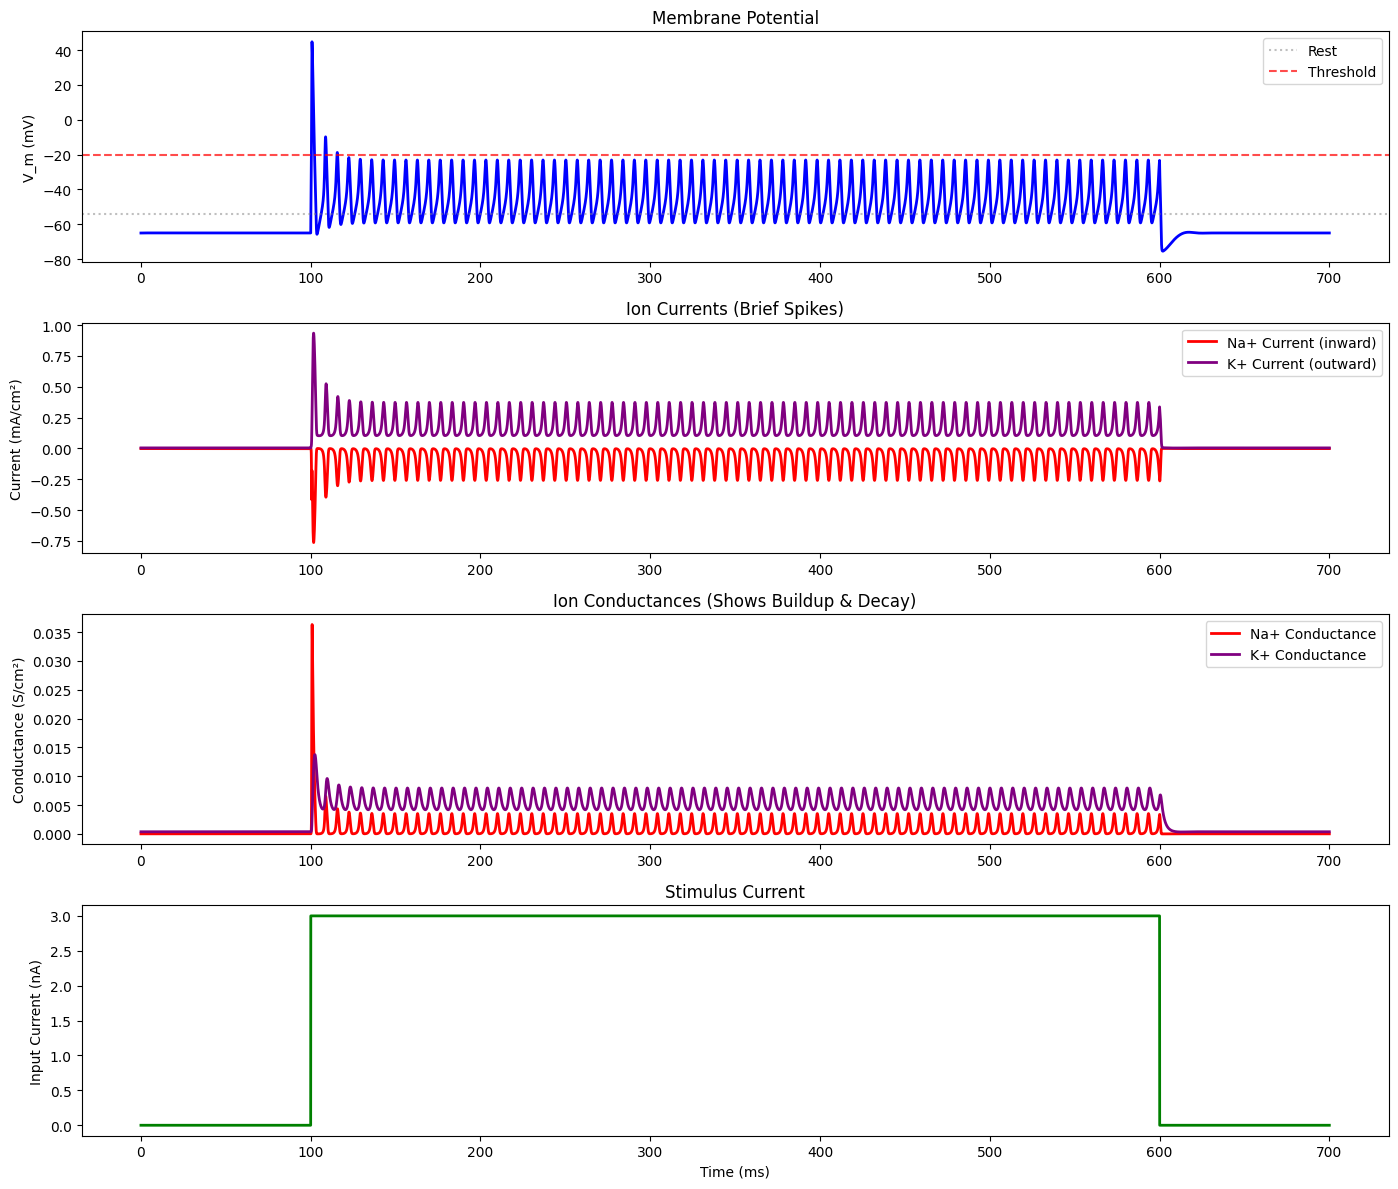

Number of spikes: 3
Max Na+ conductance: 0.0363 S/cm²
Max K+ conductance: 0.0137 S/cm²
K+ conductance at end: 0.0004 S/cm² (should be elevated)


In [3]:
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt

# --- Model setup ---
h.load_file("stdrun.hoc")

soma = h.Section(name='soma')
soma.L = 30
soma.diam = 30
soma.Ra = 100
soma.cm = 1

# Standard Hodgkin-Huxley parameters
soma.insert('hh')
for seg in soma:
    seg.hh.gnabar = 0.12   # Standard Na+ conductance
    seg.hh.gkbar = 0.036   # Standard K+ conductance
    seg.hh.gl = 0.0003     # Leak conductance
    seg.hh.el = -54.3      # Leak reversal potential

# Current injection
stim = h.IClamp(soma(0.5))
stim.delay = 100
stim.dur = 500
stim.amp = 3

# Recording vectors
t = h.Vector().record(h._ref_t)
v = h.Vector().record(soma(0.5)._ref_v)
ina = h.Vector().record(soma(0.5)._ref_ina)
ik = h.Vector().record(soma(0.5)._ref_ik)

# Spike detection and recording
spike_times = h.Vector()
nc = h.NetCon(soma(0.5)._ref_v, None, sec=soma)
nc.threshold = -20
nc.record(spike_times)

# NEW: Record gating variables and conductances
m = h.Vector().record(soma(0.5).hh._ref_m)  # Na+ activation
h_gate = h.Vector().record(soma(0.5).hh._ref_h)  # Na+ inactivation
n = h.Vector().record(soma(0.5).hh._ref_n)  # K+ activation

# Run simulation
h.finitialize(-65)
h.continuerun(700)
spikes = np.array(list(spike_times))

# Convert to arrays
t = np.array(t)
v = np.array(v)
ina = np.array(ina)
ik = np.array(ik)
m = np.array(m)
h_gate = np.array(h_gate)
n = np.array(n)

# Calculate conductances
gna = 0.12 * (m**3) * h_gate  # Sodium conductance
gk = 0.036 * (n**4)           # Potassium conductance

# Plotting
plt.figure(figsize=(14, 12))

# Membrane potential
plt.subplot(4, 1, 1)
plt.plot(t, v, 'b', linewidth=2)
plt.axhline(-54.3, color='gray', linestyle=':', alpha=0.5, label='Rest')
plt.axhline(-20, color='r', linestyle='--', alpha=0.7, label='Threshold')
plt.ylabel('V_m (mV)')
plt.legend()
plt.title('Membrane Potential')

# Ion CURRENTS (what you were plotting before)
plt.subplot(4, 1, 2)
plt.plot(t, ina, 'r', label='Na+ Current (inward)', linewidth=2)
plt.plot(t, ik, 'purple', label='K+ Current (outward)', linewidth=2)
plt.ylabel('Current (mA/cm²)')
plt.legend()
plt.title('Ion Currents (Brief Spikes)')

# Ion CONDUCTANCES (what you want to see)
plt.subplot(4, 1, 3)
plt.plot(t, gna, 'r', label='Na+ Conductance', linewidth=2)
plt.plot(t, gk, 'purple', label='K+ Conductance', linewidth=2)
plt.ylabel('Conductance (S/cm²)')
plt.legend()
plt.title('Ion Conductances (Shows Buildup & Decay)')

# Input current
plt.subplot(4, 1, 4)
input_current = [stim.amp if (stim.delay <= x < stim.delay + stim.dur) else 0 for x in t]
plt.plot(t, input_current, 'g', linewidth=2)
plt.ylabel('Input Current (nA)')
plt.xlabel('Time (ms)')
plt.title('Stimulus Current')

plt.tight_layout()
plt.show()

# Analysis
print(f"Number of spikes: {len(spikes)}")
print(f"Max Na+ conductance: {np.max(gna):.4f} S/cm²")
print(f"Max K+ conductance: {np.max(gk):.4f} S/cm²")
print(f"K+ conductance at end: {gk[-1]:.4f} S/cm² (should be elevated)")


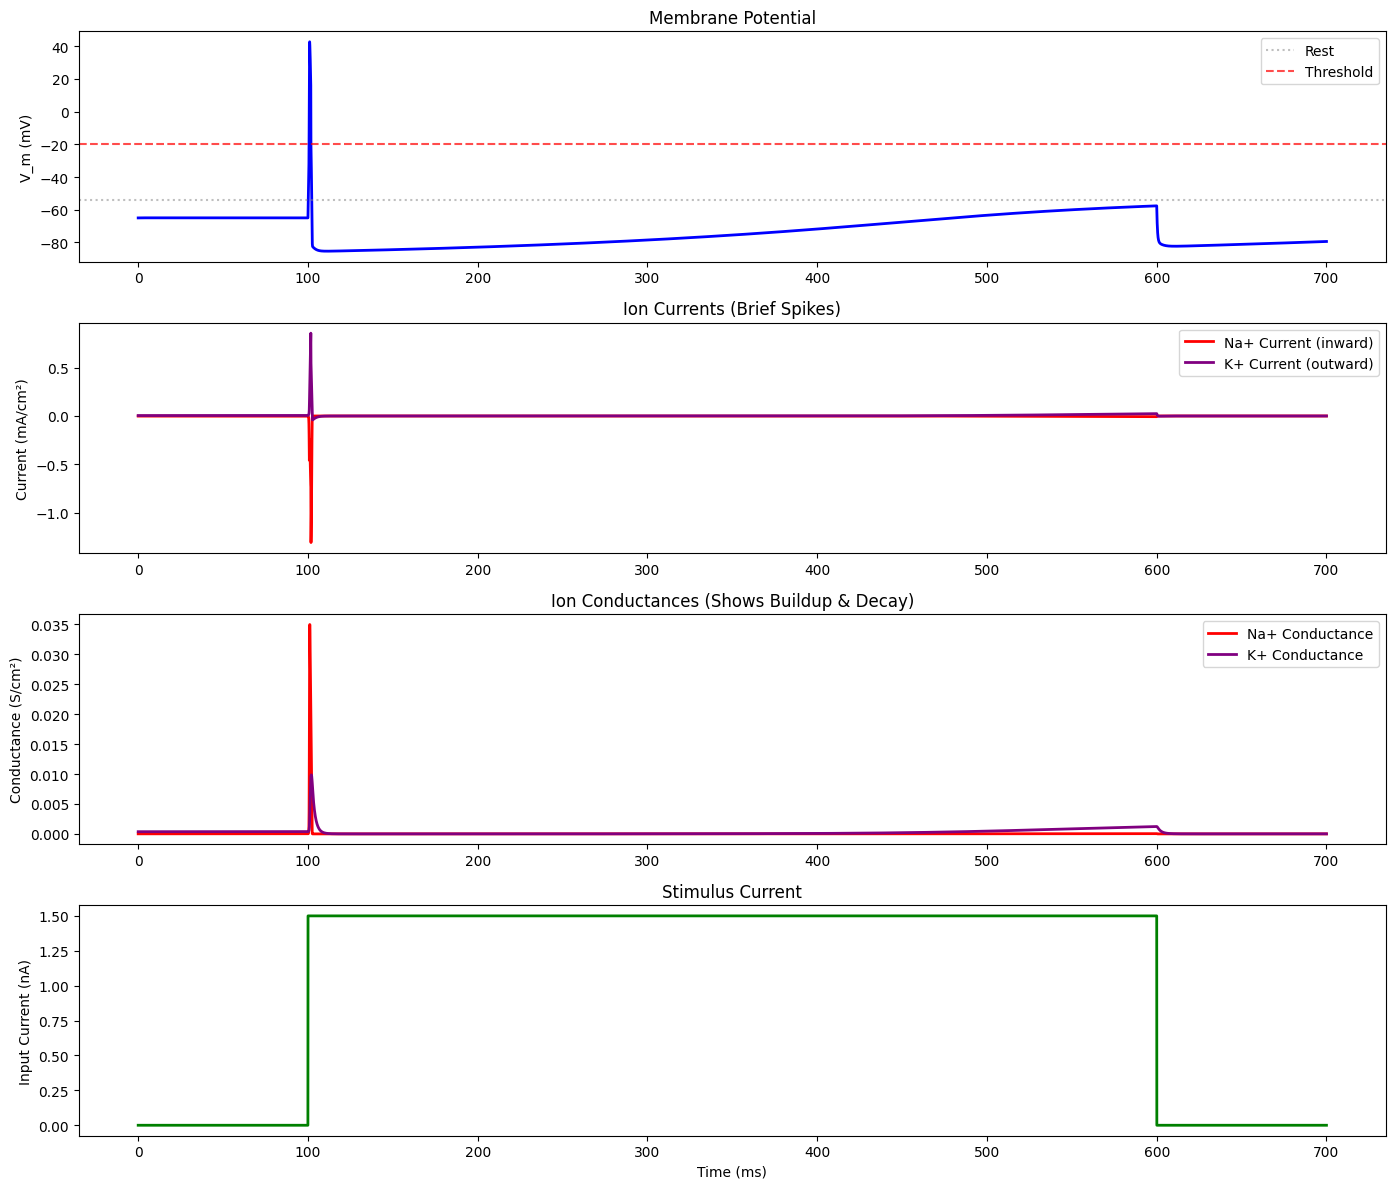

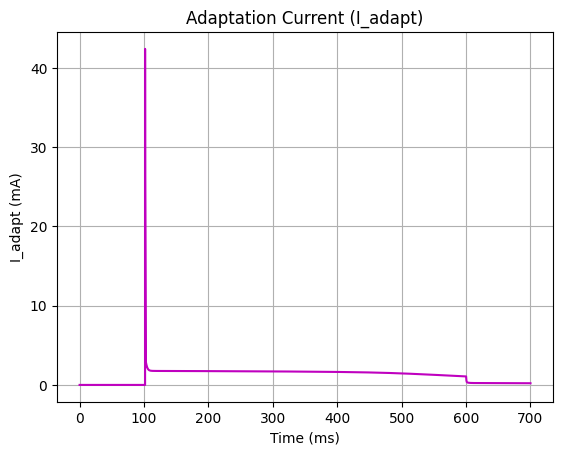

Number of spikes: 1
Max Na+ conductance: 0.0350 S/cm²
Max K+ conductance: 0.0099 S/cm²
K+ conductance at end: 0.0000 S/cm² (should be elevated)
Not enough spikes to compute ISIs.


In [46]:
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt

# --- Model setup ---
h.load_file("stdrun.hoc")

soma = h.Section(name='soma')
soma.L = 30
soma.diam = 30
soma.Ra = 100
soma.cm = 1

# Standard Hodgkin-Huxley parameters
soma.insert('hh')
for seg in soma:
    seg.hh.gnabar = 0.12   # Standard Na+ conductance
    seg.hh.gkbar = 0.036   # Standard K+ conductance
    seg.hh.gl = 0.0003     # Leak conductance
    seg.hh.el = -54.3      # Leak reversal potential

# Current injection
stim = h.IClamp(soma(0.5))
# Adaptation mechanism (POINT_PROCESS)
adapt_mech = h.Adapt(soma(0.5))
adapt_mech.gmax = 0.4  # Max conductance (S) — adjust for stronger/weaker adaptation
adapt_mech.tau = 200   # Decay time constant (ms) — higher = slower decay

stim.delay = 100
stim.dur = 500
stim.amp = 1.5

# Recording vectors
t = h.Vector().record(h._ref_t)
v = h.Vector().record(soma(0.5)._ref_v)
ina = h.Vector().record(soma(0.5)._ref_ina)
ik = h.Vector().record(soma(0.5)._ref_ik)

# Spike detection and recording
spike_times = h.Vector()
nc = h.NetCon(soma(0.5)._ref_v, None, sec=soma)
nc.threshold = -20
nc.record(spike_times)
# Trigger adaptation mechanism with spike threshold
adapt_nc = h.NetCon(soma(0.5)._ref_v, adapt_mech, sec=soma)
adapt_nc.threshold = -20
adapt_nc.weight[0] = 1  # Strength of adaptation trigger per spike


# NEW: Record gating variables and conductances
m = h.Vector().record(soma(0.5).hh._ref_m)  # Na+ activation
h_gate = h.Vector().record(soma(0.5).hh._ref_h)  # Na+ inactivation
n = h.Vector().record(soma(0.5).hh._ref_n)  # K+ activation
iadapt = h.Vector().record(adapt_mech._ref_iadapt)

# Run simulation
h.finitialize(-65)
h.continuerun(700)
spikes = np.array(list(spike_times))

# Convert to arrays
iadapt = np.array(iadapt)
t = np.array(t)
v = np.array(v)
ina = np.array(ina)
ik = np.array(ik)
m = np.array(m)
h_gate = np.array(h_gate)
n = np.array(n)

# Calculate conductances
gna = 0.12 * (m**3) * h_gate  # Sodium conductance
gk = 0.036 * (n**4)           # Potassium conductance

# Plotting
plt.figure(figsize=(14, 12))

# Membrane potential
plt.subplot(4, 1, 1)
plt.plot(t, v, 'b', linewidth=2)
plt.axhline(-54.3, color='gray', linestyle=':', alpha=0.5, label='Rest')
plt.axhline(-20, color='r', linestyle='--', alpha=0.7, label='Threshold')
plt.ylabel('V_m (mV)')
plt.legend()
plt.title('Membrane Potential')

# Ion CURRENTS (what you were plotting before)
plt.subplot(4, 1, 2)
plt.plot(t, ina, 'r', label='Na+ Current (inward)', linewidth=2)
plt.plot(t, ik, 'purple', label='K+ Current (outward)', linewidth=2)
plt.ylabel('Current (mA/cm²)')
plt.legend()
plt.title('Ion Currents (Brief Spikes)')

# Ion CONDUCTANCES (what you want to see)
plt.subplot(4, 1, 3)
plt.plot(t, gna, 'r', label='Na+ Conductance', linewidth=2)
plt.plot(t, gk, 'purple', label='K+ Conductance', linewidth=2)
plt.ylabel('Conductance (S/cm²)')
plt.legend()
plt.title('Ion Conductances (Shows Buildup & Decay)')

# Input current
plt.subplot(4, 1, 4)
input_current = [stim.amp if (stim.delay <= x < stim.delay + stim.dur) else 0 for x in t]
plt.plot(t, input_current, 'g', linewidth=2)
plt.ylabel('Input Current (nA)')
plt.xlabel('Time (ms)')
plt.title('Stimulus Current')

plt.tight_layout()
plt.show()
plt.figure()
plt.plot(t, iadapt, 'm')
plt.title('Adaptation Current (I_adapt)')
plt.xlabel('Time (ms)')
plt.ylabel('I_adapt (mA)')
plt.grid(True)
plt.show()

# Analysis
print(f"Number of spikes: {len(spikes)}")
print(f"Max Na+ conductance: {np.max(gna):.4f} S/cm²")
print(f"Max K+ conductance: {np.max(gk):.4f} S/cm²")
print(f"K+ conductance at end: {gk[-1]:.4f} S/cm² (should be elevated)")

# Calculate ISIs (Interspike Intervals)
if len(spikes) > 1:
    isis = np.diff(spikes)
    plt.figure()
    plt.plot(spikes[1:], isis, marker='o', linestyle='-', color='teal')
    plt.title('Interspike Intervals (ISI) Over Time')
    plt.xlabel('Spike Time (ms)')
    plt.ylabel('ISI (ms)')
    plt.grid(True)
    plt.show()

    print(f"Mean ISI: {np.mean(isis):.2f} ms")
    print(f"First ISI: {isis[0]:.2f} ms")
    print(f"Last ISI: {isis[-1]:.2f} ms")
    print(f"ISI increase: {isis[-1] - isis[0]:.2f} ms")
else:
    print("Not enough spikes to compute ISIs.")



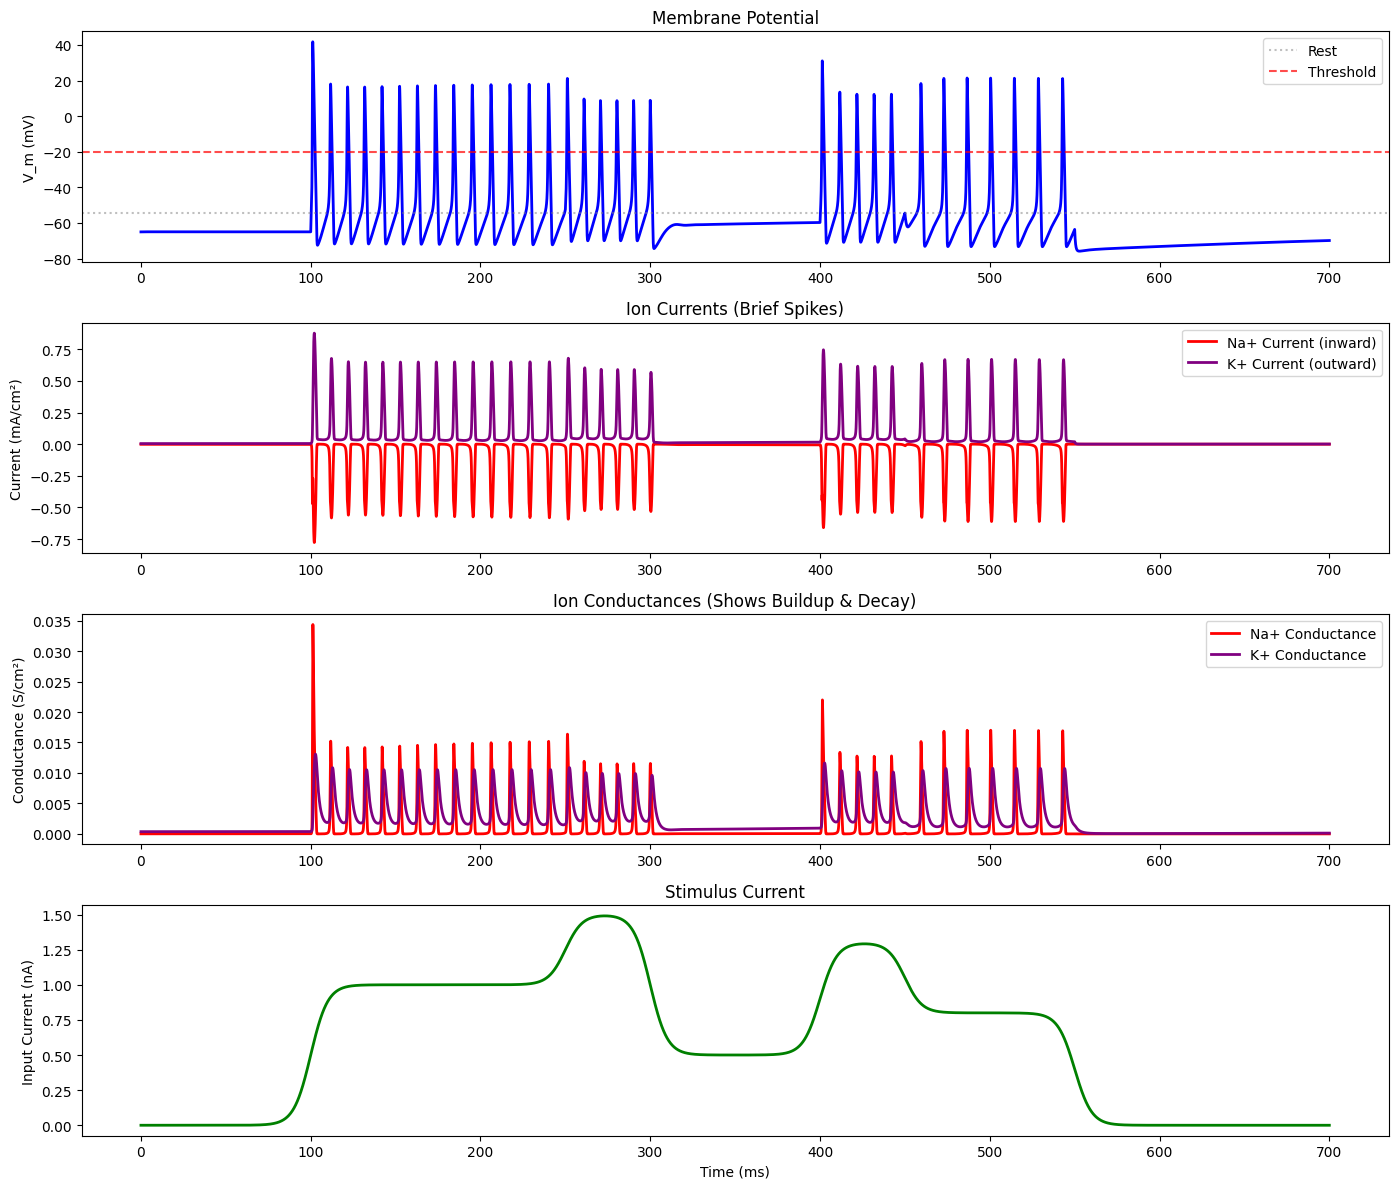

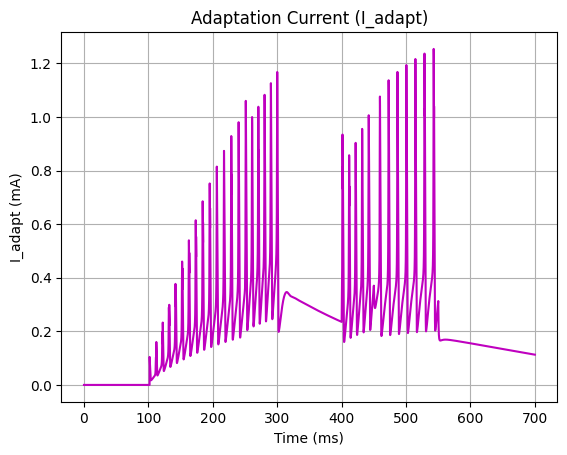

Number of spikes: 32
Max Na+ conductance: 0.0344 S/cm²
Max K+ conductance: 0.0131 S/cm²
K+ conductance at end: 0.0001 S/cm² (should be elevated)


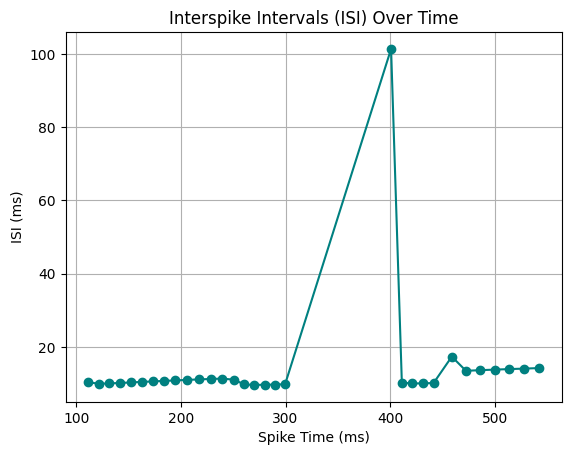

Mean ISI: 14.25 ms
First ISI: 10.45 ms
Last ISI: 14.28 ms
ISI increase: 3.83 ms


In [1]:
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt

# --- Model setup ---
h.load_file("stdrun.hoc")

soma = h.Section(name='soma')
soma.L = 30
soma.diam = 30
soma.Ra = 100
soma.cm = 1

# Standard Hodgkin-Huxley parameters
soma.insert('hh')
for seg in soma:
    seg.hh.gnabar = 0.12   # Standard Na+ conductance
    seg.hh.gkbar = 0.036   # Standard K+ conductance
    seg.hh.gl = 0.0003     # Leak conductance
    seg.hh.el = -54.3      # Leak reversal potential


# Adaptation mechanism (POINT_PROCESS)
adapt_mech = h.Adapt(soma(0.5))
adapt_mech.gmax = 0.001  # Max conductance (S) — adjust for stronger/weaker adaptation
adapt_mech.tau = 200     # Decay time constant (ms) — higher = slower decay

# Current injection
# First input current
stim1 = h.IClamp(soma(0.5))
stim1.delay = 100
stim1.dur = 200
stim1.amp = 1.0

# Second input current — starts while first is still ongoing
stim2 = h.IClamp(soma(0.5))
stim2.delay = 250
stim2.dur = 200
stim2.amp = 0.5

stim3 = h.IClamp(soma(0.5))
stim3.delay = 400
stim3.dur = 150
stim3.amp = 0.8



# Recording vectors
t = h.Vector().record(h._ref_t)
v = h.Vector().record(soma(0.5)._ref_v)
ina = h.Vector().record(soma(0.5)._ref_ina)
ik = h.Vector().record(soma(0.5)._ref_ik)

# Spike detection and recording
spike_times = h.Vector()
nc = h.NetCon(soma(0.5)._ref_v, None, sec=soma)
nc.threshold = -20
nc.record(spike_times)
# Trigger adaptation mechanism with spike threshold
adapt_nc = h.NetCon(soma(0.5)._ref_v, adapt_mech, sec=soma)
adapt_nc.threshold = -20
adapt_nc.weight[0] = 1  # Strength of adaptation trigger per spike


# NEW: Record gating variables and conductances
m = h.Vector().record(soma(0.5).hh._ref_m)  # Na+ activation
h_gate = h.Vector().record(soma(0.5).hh._ref_h)  # Na+ inactivation
n = h.Vector().record(soma(0.5).hh._ref_n)  # K+ activation
iadapt = h.Vector().record(adapt_mech._ref_iadapt)

# Run simulation
h.finitialize(-65)
h.continuerun(700)
spikes = np.array(list(spike_times))

# Convert to arrays
iadapt = np.array(iadapt)
t = np.array(t)
v = np.array(v)
ina = np.array(ina)
ik = np.array(ik)
m = np.array(m)
h_gate = np.array(h_gate)
n = np.array(n)


# Calculate conductances
gna = 0.12 * (m**3) * h_gate  # Sodium conductance
gk = 0.036 * (n**4)           # Potassium conductance
def smooth_pulse(t, delay, dur, amp, rise=5, fall=5):
    """Return a smooth pulse using sigmoid edges.
    rise/fall: ms over which the edge transitions (higher = smoother)."""
    onset = 1 / (1 + np.exp(-(t - delay) / rise))
    offset = 1 / (1 + np.exp(-(t - (delay + dur)) / fall))
    return amp * (onset - offset)

input_current = (
    smooth_pulse(t, stim1.delay, stim1.dur, stim1.amp, rise=5, fall=5) +
    smooth_pulse(t, stim2.delay, stim2.dur, stim2.amp, rise=5, fall=5) +
    smooth_pulse(t, stim3.delay, stim3.dur, stim3.amp, rise=5, fall=5)
)

# Plotting
plt.figure(figsize=(14, 12))

# Membrane potential
plt.subplot(4, 1, 1)
plt.plot(t, v, 'b', linewidth=2)
plt.axhline(-54.3, color='gray', linestyle=':', alpha=0.5, label='Rest')
plt.axhline(-20, color='r', linestyle='--', alpha=0.7, label='Threshold')
plt.ylabel('V_m (mV)')
plt.legend()
plt.title('Membrane Potential')

# Ion CURRENTS (what you were plotting before)
plt.subplot(4, 1, 2)
plt.plot(t, ina, 'r', label='Na+ Current (inward)', linewidth=2)
plt.plot(t, ik, 'purple', label='K+ Current (outward)', linewidth=2)
plt.ylabel('Current (mA/cm²)')
plt.legend()
plt.title('Ion Currents (Brief Spikes)')

# Ion CONDUCTANCES (what you want to see)
plt.subplot(4, 1, 3)
plt.plot(t, gna, 'r', label='Na+ Conductance', linewidth=2)
plt.plot(t, gk, 'purple', label='K+ Conductance', linewidth=2)
plt.ylabel('Conductance (S/cm²)')
plt.legend()
plt.title('Ion Conductances (Shows Buildup & Decay)')

# Input current
plt.subplot(4, 1, 4)
plt.plot(t, input_current, 'g', linewidth=2)
plt.ylabel('Input Current (nA)')
plt.xlabel('Time (ms)')
plt.title('Stimulus Current')

plt.tight_layout()
plt.show()
plt.figure()
plt.plot(t, iadapt, 'm')
plt.title('Adaptation Current (I_adapt)')
plt.xlabel('Time (ms)')
plt.ylabel('I_adapt (mA)')
plt.grid(True)
plt.show()

# Analysis
print(f"Number of spikes: {len(spikes)}")
print(f"Max Na+ conductance: {np.max(gna):.4f} S/cm²")
print(f"Max K+ conductance: {np.max(gk):.4f} S/cm²")
print(f"K+ conductance at end: {gk[-1]:.4f} S/cm² (should be elevated)")

# Calculate ISIs (Interspike Intervals)
if len(spikes) > 1:
    isis = np.diff(spikes)
    plt.figure()
    plt.plot(spikes[1:], isis, marker='o', linestyle='-', color='teal')
    plt.title('Interspike Intervals (ISI) Over Time')
    plt.xlabel('Spike Time (ms)')
    plt.ylabel('ISI (ms)')
    plt.grid(True)
    plt.show()

    print(f"Mean ISI: {np.mean(isis):.2f} ms")
    print(f"First ISI: {isis[0]:.2f} ms")
    print(f"Last ISI: {isis[-1]:.2f} ms")
    print(f"ISI increase: {isis[-1] - isis[0]:.2f} ms")
else:
    print("Not enough spikes to compute ISIs.")



In [35]:
gmax_values = [0.0005, 0.001, 0.002, 0.003, 0.004]
tau_values = [50, 100, 200, 400, 800]
isi_increase = np.zeros((len(gmax_values), len(tau_values)))
num_spikes = np.zeros((len(gmax_values), len(tau_values)))

for i, gmax in enumerate(gmax_values):
    for j, tau in enumerate(tau_values):
        # Reset model
        soma = h.Section(name='soma')
        soma.L = 30
        soma.diam = 30
        soma.Ra = 100
        soma.cm = 1
        soma.insert('hh')
        for seg in soma:
            seg.hh.gnabar = 0.12
            seg.hh.gkbar = 0.036
            seg.hh.gl = 0.0003
            seg.hh.el = -54.3

        adapt_mech = h.Adapt(soma(0.5))
        adapt_mech.gmax = gmax
        adapt_mech.tau = tau

        stim1 = h.IClamp(soma(0.5))
        stim1.delay = 100
        stim1.dur = 200
        stim1.amp = 1.0
        stim2 = h.IClamp(soma(0.5))
        stim2.delay = 250
        stim2.dur = 200
        stim2.amp = 0.5
        stim3 = h.IClamp(soma(0.5))
        stim3.delay = 400
        stim3.dur = 150
        stim3.amp = 0.8

        t_vec = h.Vector().record(h._ref_t)
        v_vec = h.Vector().record(soma(0.5)._ref_v)
        spike_times = h.Vector()
        nc = h.NetCon(soma(0.5)._ref_v, None, sec=soma)
        nc.threshold = -20
        nc.record(spike_times)
        adapt_nc = h.NetCon(soma(0.5)._ref_v, adapt_mech, sec=soma)
        adapt_nc.threshold = -20
        adapt_nc.weight[0] = 1

        h.finitialize(-65)
        h.continuerun(700)
        spikes = np.array(list(spike_times))
        if len(spikes) > 1:
            isis = np.diff(spikes)
            isi_increase[i, j] = isis[-1] - isis[0]
            num_spikes[i, j] = len(spikes)
        else:
            isi_increase[i, j] = np.nan
            num_spikes[i, j] = 0


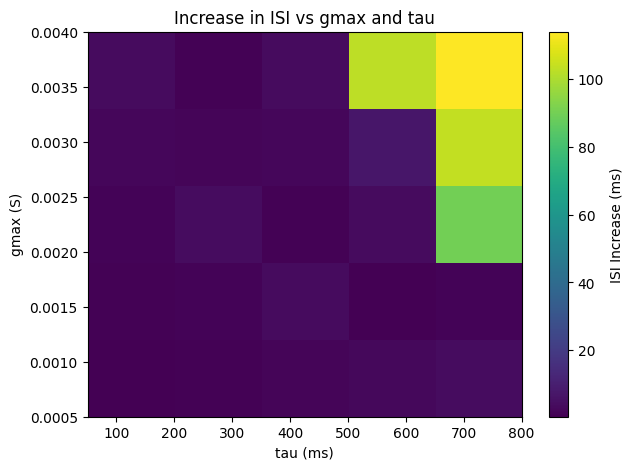

In [36]:
plt.figure(figsize=(7,5))
plt.imshow(isi_increase, aspect='auto', origin='lower',
           extent=[min(tau_values), max(tau_values), min(gmax_values), max(gmax_values)],
           cmap='viridis')
plt.colorbar(label='ISI Increase (ms)')
plt.xlabel('tau (ms)')
plt.ylabel('gmax (S)')
plt.title('Increase in ISI vs gmax and tau')
plt.show()


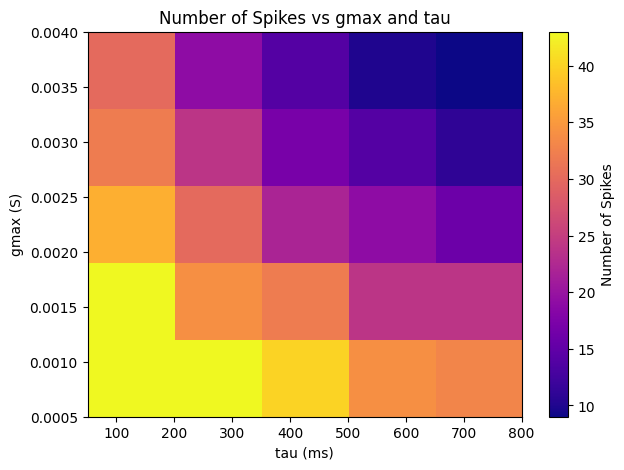

In [37]:
plt.figure(figsize=(7,5))
plt.imshow(num_spikes, aspect='auto', origin='lower',
           extent=[min(tau_values), max(tau_values), min(gmax_values), max(gmax_values)],
           cmap='plasma')
plt.colorbar(label='Number of Spikes')
plt.xlabel('tau (ms)')
plt.ylabel('gmax (S)')
plt.title('Number of Spikes vs gmax and tau')
plt.show()
